In [16]:
using Plots, Random, Distributions, StatsBase, Printf, LaTeXStrings, 
    DataFrames, StatsPlots, KernelDensity, LinearAlgebra
default(fillcolor=:lightgrey, markercolor=:black, markersize=2,
    grid=false, legend=false, titlefontsize=10)

# Metropolis-Hastings Algorithm

## Metropolis-Hastings Random Walk

Starting with $\mathbf{X_{(0)}} := (X_1^{(0)}, \ldots, X_p^{(0)})$ and using a symmetric distribution $g$, iterate for $t=1, 2, \ldots$:
1. Draw $\epsilon \sim g$ and set $\mathbf{X} = \mathbf{X}^{(t-1)} + \epsilon$
2. Compute
$$\alpha(\mathbf{X}|\mathbf{X}^{(t-1)}) = \min\left\{1, \frac{f(\mathbf{X})}{f(\mathbf{X}^{t-1)})}\right\}$$
3. With probability $\alpha(\mathbf{X}|\mathbf{X}^{(t-1)})$ set $\mathbf{X}^{(t)} = \mathbf{X}$, otherwise set $\mathbf{X}^{(t)} = \mathbf{X}^{(t-1)}$.

In [19]:
function mrw_sample(;target, proposal, X0, N=1000)
    X = Array{Float64, 1}(undef, N)
    X[1] = X0
    for t in range(2, N)
        X[t] = X[t - 1] + rand(proposal)
        u = rand(Uniform())
        if u > pdf(target, (X[t])) / pdf(target, (X[t-1]))
            X[t] = X[t - 1]
        end
    end
    X
end

mrw_sample (generic function with 1 method)

### Sampling from $N(0, 1)$  with proposal $N(0, \sigma^2)$

In [21]:
N = 5000
sigmas = [0.1, 1, 2.38, 10]
df = Normal()
X = Array{Float64, 2}(undef, N, 4)
for i in range(1, 4)
    g = Normal(0, sigmas[i])
    X[:,i] = mrw_sample(target=df, proposal=g, X0=0, N=N)
end

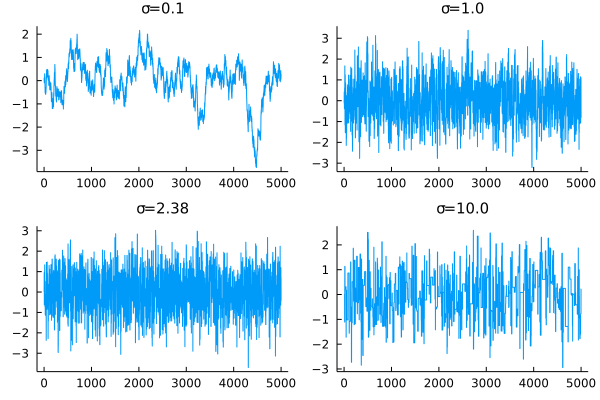

In [22]:
#sample paths
p = plot(layout=(2,2))
for i in range(1,4)
    s = sigmas[i]
    plot!(p, X[:, i], layout=(2, 2), subplot=i, title="\\sigma=$s")
end
p

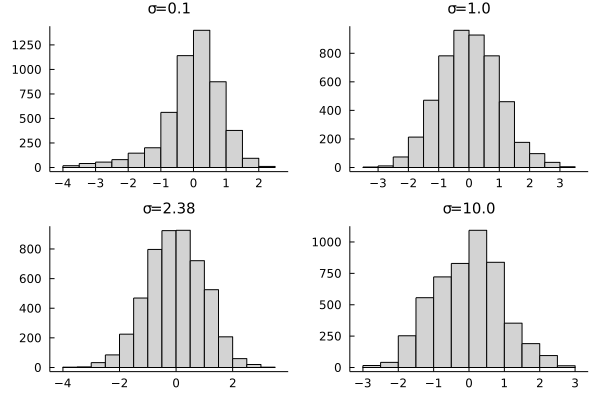

In [23]:
#histograms
p = plot(layout=(2,2))
for i in range(1,4)
    s = sigmas[i]
    histogram!(p, X[:, i], layout=(2, 2), subplot=i, 
        title="\\sigma=$s", bins=15)
end
p

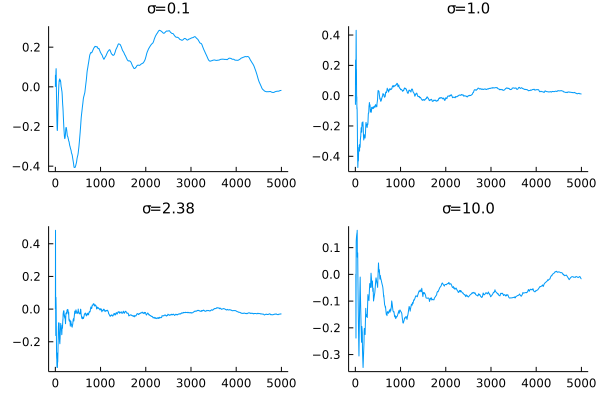

In [24]:
# cumulative averages
#histograms
p = plot(layout=(2,2))
for i in range(1,4)
    s = sigmas[i]
    plot!(p, cumsum(X[:, i]) ./ [1:1:N;], layout=(2, 2), subplot=i, 
        title="\\sigma=$s", bins=15)
end
p

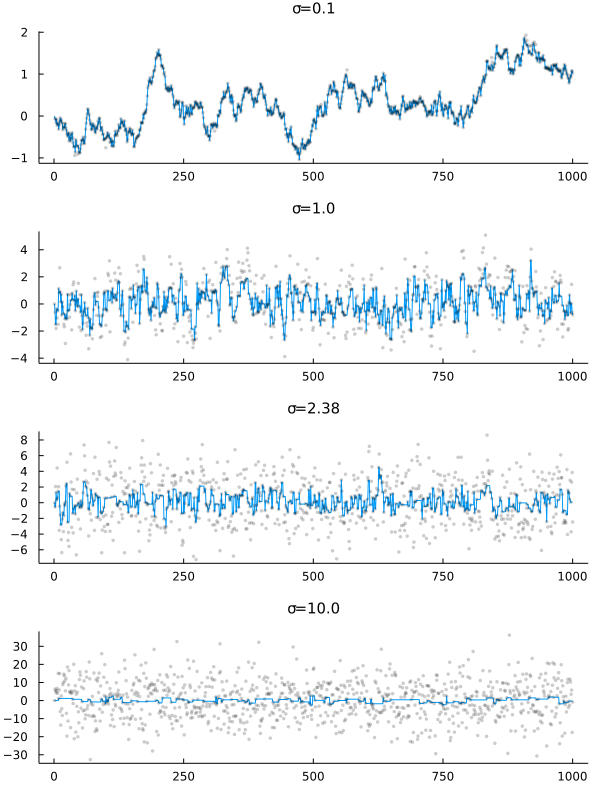

In [70]:
function mrw_sample2(;target, proposal, X0, N=1000)
    X = Array{Float64, 1}(undef, N)  # accepted values
    Y = Array{Float64, 1}(undef, N)  # all values
    X[1] = X0
    for t in range(2, N)
        Y[t] = X[t] = X[t - 1] + rand(proposal)
        u = rand(Uniform())
        if u > pdf(target, (X[t])) / pdf(target, (X[t - 1]))
            X[t] = X[t-1]
        end
    end
    X, Y
end

N = 1000
sigmas = [0.1, 1, 2.38, 10]
df = Normal()
X = Array{Float64, 2}(undef, N, 4)
Y = Array{Float64, 2}(undef, N, 4)

for i in range(1, 4)
    g = Normal(0, sigmas[i])
    X[:, i], Y[:, i] = mrw_sample2(target=df, proposal=g, X0=0, N=N)
end

p = plot(layout=(4, 1), size = (600, 800))
for i in range(1,4)
    s = sigmas[i]
    plot!(p, X[:, i], layout=(4, 1), subplot=i, 
        title="\\sigma=$s")
    scatter!(p, Y[:, i], layout=(4, 1), subplot=i, 
        title="\\sigma=$s", markeralpha = 0.2)
end
p

### Bayesian probit model

In [85]:
using CSV, CategoricalArrays

# data import
data = CSV.read("data/caesar.csv", DataFrame, drop=[1])
data[!, "planned"] = recode(categorical(data[!, "noplan"]), "not"=>0, "planned"=>1)
data[!, "risk factors"] = recode(categorical(data[!, "factor"]), "risk factors"=>1, "without"=>0)
data[!, "antibiotics"] = recode(categorical(data[!, "antib"]), "antibiotics"=>1, "without"=>0)
data[!, "total"] = data[!, "w"]
data = data[!, ["y", "total", "planned", "risk factors", "antibiotics"]]
first(data, 5)

5×5 DataFrame
 Row │ y      total  planned  risk factors  antibiotics 
     │ Int64  Int64  Cat…     Cat…          Cat…        
─────┼──────────────────────────────────────────────────
   1 │     3     87  0        1             1
   2 │     1      4  0        1             1
   3 │     2      7  0        1             1
   4 │     2     13  0        1             0
   5 │     1     10  0        1             0

Data can be modelled by assuming that:
$$Y_i \sim Bin(n_i, \pi_i) \quad \pi = \Phi(\mathbf{z}_i^T\mathbf{\beta})$$
Where $\mathbf{z}_i = (1, z_{i1}, z_{i2}, z_{i3})$ and $\Phi(\cdot)$ being the CDF of $N(0,1)$ dsitribution.

Prior:
$$\mathbf{\beta} \sim N\left(\mathbf{0}, \frac{1}{\lambda}I\right)$$

Posterior:
$$f(\mathbf{\beta}| y_1, \ldots, y_n) \propto \left(\prod_{i=1}^{n}\Phi(\mathbf{z}_i^T\mathbf{\beta})^{y_i} 
\dot (1 - \Phi(\mathbf{z}_i^T\mathbf{\beta}))^{n_i - y_i}\right)
\cdot \exp{\left(-\frac{\lambda}{2}\sum_{j=0}^{3}\beta_j^2\right)}$$

In [215]:
function beta_post(beta, Y, W, Z)
    log_post = sum(Y .* log.(cdf.(Normal(), Z * beta)) 
    + (W .- Y) .* log.(1 .- cdf.(Normal(), Z * beta)))
    - (lambda / 2) * dot(beta, beta)
    post = exp(log_post)
    post
end

function mrw_data_sample(;Y, W, Z, prior_beta, proposal, N=50000)
    B = Array{Float64, 2}(undef, N, 4)
    B[1,:] = rand(prior_beta)
    for t in range(2, N)
        B[t,:] = B[t - 1,:] .+ rand(proposal)
        u = rand(Uniform())
        if u > beta_post(B[t,:], Y, W, Z) / beta_post(B[t - 1,:], Y, W, Z) 
            B[t,:] = B[t - 1,:]
        end
    end
    B
end

mrw_data_sample (generic function with 1 method)

In [222]:
Y = data[!, "y"]
W = data[!, "total"]
Z = convert(Matrix{Int64}, 
    Matrix(data[!, ["planned", "risk factors", "antibiotics"]]))
Z = hcat(fill(1, length(Y)), Z)

lambda = 1
prior_beta = MvNormal(zeros(4), lambda * I)
sigma = 0.08
proposal = MvNormal(zeros(4), sigma * I)

beta = mrw_data_sample(Y=Y, W=W, Z=Z, prior_beta=prior_beta, proposal=proposal);

In [223]:
# sample paths
p = plot(layout=(2,2))
for i in range(1,4)
    plot!(p, beta[:, i], layout=(2, 2), subplot=i, title="\\beta_{$i}")
end
p

In [224]:
# cumulative averages
p = plot(layout=(2,2))
for i in range(1,4)
    plot!(p, cumsum(beta[:, i]) ./ [1:1:size(beta)[1];], layout=(2, 2), 
        subplot=i, title="\\beta_{$i}")
end
p

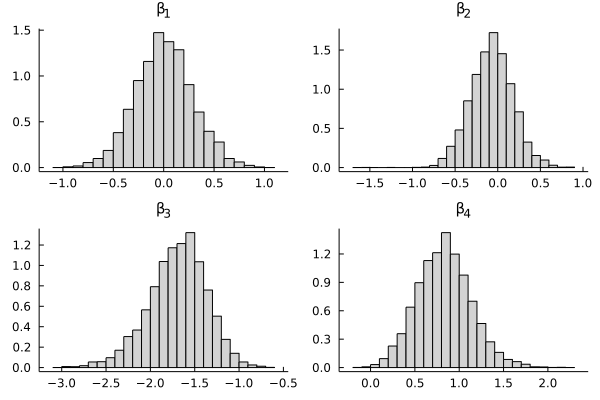

In [225]:
# histograms
p = plot(layout=(2,2))
for i in range(1,4)
    histogram!(p, beta[:, i], layout=(2, 2), subplot=i, bins=30, 
        normed=true, title="\\beta_{$i}")
end
p

In [227]:
# Autocorrelations
autocor(beta, [1])

1×4 Matrix{Float64}:
 0.964347  0.947322  0.969108  0.961506